# KRAMERS TIME-DEPENDENT RATES (KTR) METHOD

## Introduction

In this tutorial we illustrate the use of the KTR method to estimate the intrinsic rate (k_o) and the quality of bias (gamma) from metadynamics simulations by fitting numerically the cumulative distribution function.

We provide the scripts for the analysis of the COLVAR files from PLUMED.

Reference paper: Palacio-Rodriguez, Vroylandt, Stelzl, Pietrucci, Hummer, & Cossio. (2021) [arXiv:2109.11360](https://arxiv.org/abs/2109.11360).

In [11]:
import numpy as np
import glob
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [25]:
# Load all colvar files
numprocs = 8
colvars = glob.glob("colvars/*")
colvars_count = len(colvars)
colvars_maxrow_count = None

data = []
for colvar in colvars:
    data.append(np.loadtxt(colvar))
    colvars_maxrow_count = data[-1].shape[0] if colvars_maxrow_count is None or colvars_maxrow_count < data[-1].shape[0] else colvars_maxrow_count

# Print first lines to check that the data is loaded correctly
print(f'Number of colvar files    : {colvars_count}')
print(f'Max number of overall rows: {colvars_maxrow_count}')
print('Example of loaded data:')
print('#! FIELDS time d metad.bias acceleration.factor') # Corresponding columns for our example
print(data[0][:10])

Number of colvar files    : 50
Max number of overall rows: 34253
Example of loaded data:
#! FIELDS time d metad.bias acceleration.factor
[[0.       1.676266 0.       1.      ]
 [0.1      1.672725 0.       1.      ]
 [0.2      1.673073 0.       1.      ]
 [0.3      1.676354 0.       1.      ]
 [0.4      1.677375 0.       1.      ]
 [0.5      1.674929 0.       1.      ]
 [0.6      1.671249 0.       1.      ]
 [0.7      1.66508  0.       1.      ]
 [0.8      1.660368 0.       1.      ]
 [0.9      1.658337 0.       1.      ]]


In [28]:
# Estimate maximum bias for each colvar file
def set_max_accumulate(dataset, numcol = 2):
    max_value_found = None
    for i in range(dataset.shape[0]):
        max_value_found = dataset[i][numcol] if max_value_found is None or max_value_found < dataset[i][numcol] else max_value_found
        dataset[i][numcol] = max_value_found

for i in range(colvars_count):
    set_max_accumulate(data[i])

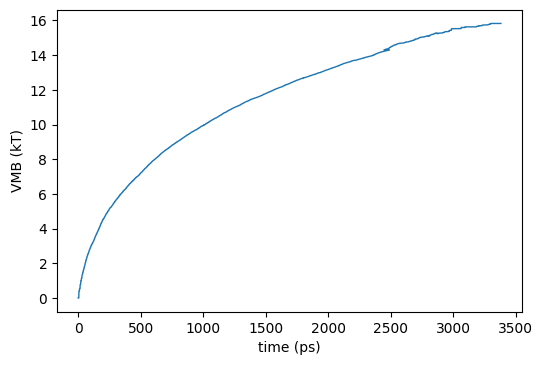

In [30]:
# Estimate average maximum bias (VMB) over all the colvars
vmb_data = np.empty((colvars_count, colvars_maxrow_count))
vmb_data.fill(np.nan)
ix_col = None

def fill_vmb_data(colvar_index):
    vmb_column_data = data[colvar_index][:,2]
    diff_rows = colvars_maxrow_count - vmb_column_data.shape[0]
    if 0 < diff_rows:
        fill_diff = np.empty(diff_rows)
        fill_diff.fill(np.nan)
        vmb_column_data = np.hstack((vmb_column_data, fill_diff))
    vmb_data[colvar_index,:] = vmb_column_data
    return data[colvar_index][:,0] if data[colvar_index][:,0].shape[0] == colvars_maxrow_count else None

for i in range(colvars_count):
    i_ix_col = fill_vmb_data(i)
    if None is not i_ix_col:
        ix_col = i_ix_col

#print(ix_col.shape[0])

g = ix_col[0]

#for i in range(1,ix_col.shape[0]):
#    if(g > ix_col[i]):
#        print(f'{ix_col[i]} ({g - ix_col[i]})')
#    else:
#        g = ix_col[i]

masked_vmb = np.ma.masked_array(vmb_data, np.isnan(vmb_data))
vmb_average = np.ma.average(masked_vmb.T, axis=1)
vmb_average = np.vstack((ix_col, vmb_average)).T

# Plot VMB
fig,ax = plt.subplots(figsize=(6,4),dpi=100)
ax.set_xlabel('time (ps)')
ax.set_ylabel('VMB (kT)')

plt.plot(vmb_average[:,0], vmb_average[:,1], lw=1.0)

In [ ]:
#Output1: VMB plot

In [5]:
#Output2: CDF fit

In [6]:
#Output3: k_0 and gamma